In [ ]:
import os
import pandas as pd
import numpy as np
import sys
from collections import OrderedDict
from IPython.display import display
import matplotlib.pyplot as plt
from numba import jit, prange, njit, config

sys.setrecursionlimit(20000)

from numba.typed import Dict, List

from scripts import test_mutation, calculate_all_fitnesses, calculate_fitness, genotype_hash,deep_copy_genotype, mutate_genotype_inplace, assert_equality_of_hashes
from scripts import random_int, NODE_TYPE, GENOTYPE_TYPE, best_n_items, create_full_tree_from_genome, seed
from scripts import create_n_genotypes, crossover_numba, selection_tournament
from tqdm.notebook import tqdm

#load_and_print_csvs_from_folders()
#test_n_creation()


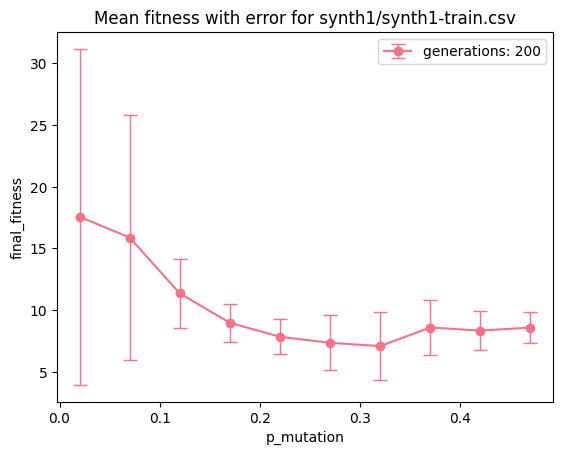

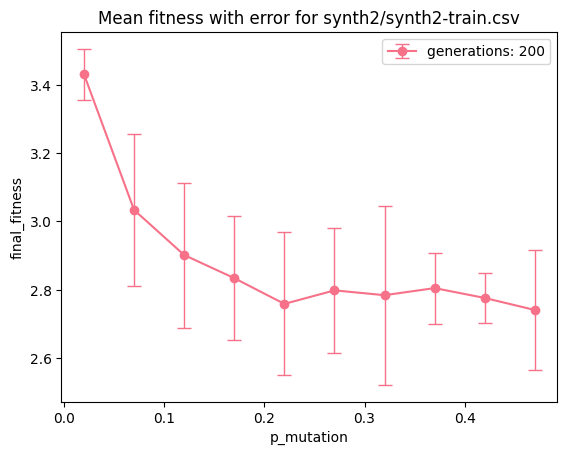

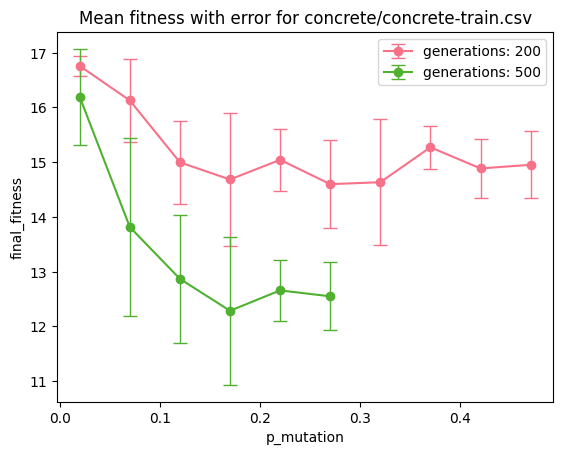

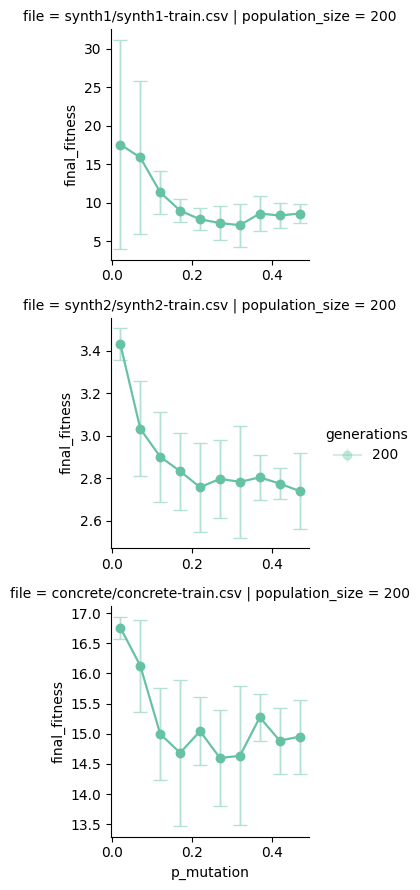

In [100]:
import seaborn as sns
import colorsys
def plot_correlation(df_correlation, target_generation_size=-1, file=None, errorbar=True):
    df = df_correlation[df_correlation["generations"] > 50]

    if target_generation_size > 0:
        df = df[df["generations"] == target_generation_size]
    if file is not None:
        df = df[df["file"] == file]

    def lineplot_with_errorbars(x, y, color, label, **kwargs):
            data = kwargs.pop("data")
            yerr = data["final_std"]

            # Create a lighter color for the error bars.
            rgb = colorsys.rgb_to_hls(*color[:3])
            light_color = colorsys.hls_to_rgb(rgb[0], 1 - 0.5 * (1 - rgb[1]), rgb[2])
            if not errorbar:
                plt.plot(data[x], data[y], color=light_color, label=label)
            else:
                plt.errorbar(x=data[x], y=data[y], yerr=yerr, fmt='-o', ecolor=light_color, elinewidth=1, capsize=5, color=color, label=label)
                plt.errorbar(x=data[x], y=data[y], yerr=yerr, fmt='-o', ecolor=light_color, elinewidth=2, capsize=0, color=color, label=label, alpha=0.3)

    g = sns.FacetGrid(df, row='file', col='population_size', hue='generations', sharex=False, sharey=False, palette="Set2")

    g = g.map_dataframe(lineplot_with_errorbars, x='p_mutation', y='final_fitness')

    g.add_legend()

    plt.show()

def plot_correlation_per_file(df_correlation, target_generation_size=-1):
    df = df_correlation[df_correlation["generations"] > 50]
    if target_generation_size > 0:
        df = df[df["generations"] == target_generation_size]

    unique_files = df['file'].unique()
    color_palette = sns.color_palette('husl', len(unique_files))
    
    for i, file in enumerate(unique_files):
        df_file = df[df["file"] == file]
   
        fig, ax = plt.subplots()
        unique_generations = df_file['generations'].unique()
        min_fitness_gen = None
        min_fitness_value = np.inf
        for i, generation in enumerate(unique_generations):
            df_generation = df_file[df_file['generations'] == generation]
            fitness = df_generation['final_fitness'] - df_generation['final_std']


            ax.errorbar(df_generation['p_mutation'], df_generation['final_fitness'], yerr=df_generation['final_std'],
                        color=color_palette[i], elinewidth=1, capsize=5, label='generations: ' + str(generation), fmt='-o')

        ax.legend()

        plt.title(f"Mean fitness with error for {file}")
        plt.xlabel('p_mutation')
        plt.ylabel('final_fitness')
        plt.show()

df_cache = pd.read_csv("cache.csv")

plot_correlation_per_file(df_cache)

plot_correlation(df_cache, 200)




Data for abs. As the stds from cache are wrong, im omitting them
population converged around 70 generations


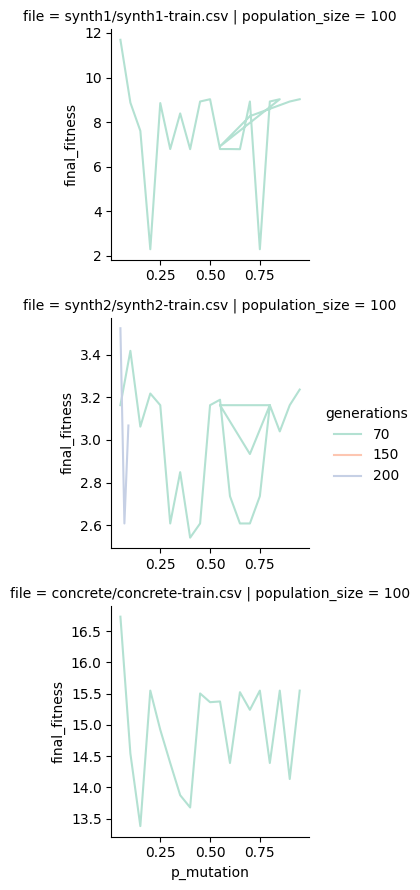

In [102]:
df_abs = pd.read_csv("cacheAbs.csv")
df_sin = pd.read_csv("cacheSin.csv")

def calculate_value(row):
    json_data = json.loads(row["std_last_gen"])
    # Calculate the value based on the JSON data
    calculated_value = json_data[-1]
    return calculated_value

df_abs['final_std'] = df_abs.apply(calculate_value, axis=1)
df_sin['final_std'] = df_sin.apply(calculate_value, axis=1)

print("Data for abs. As the stds from cache are wrong, im omitting them")
print("population converged around 70 generations")
plot_correlation(df_abs, errorbar=False)



Data for sine. As the stds from cache are wrong, im omitting them
population converged around 70 generations


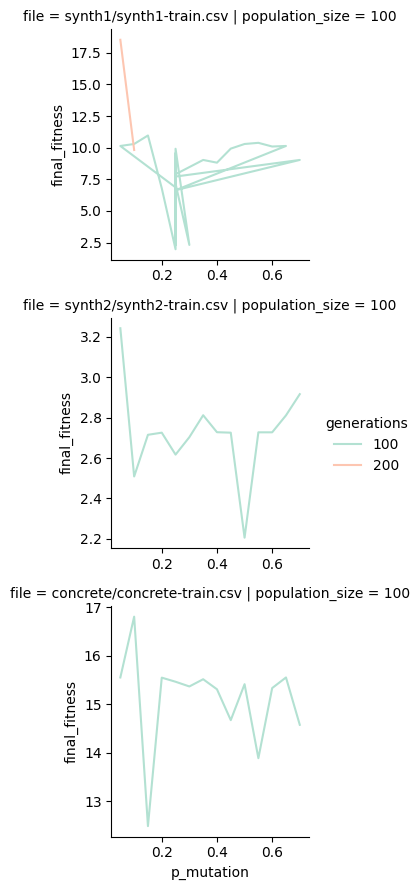

In [103]:
print("Data for sine. As the stds from cache are wrong, im omitting them")
print("population converged around 70 generations")
plot_correlation(df_sin, errorbar=False)

## Teste com biblioteca pronta de regressão simbólica

In [109]:
from gplearn.genetic import SymbolicRegressor

def parse_df(case_df):
    # y is the last column from the df, extract it to y
    y = case_df.iloc[:, -1].to_numpy()

    # drop the last column from the df, and store the rest in X
    X = case_df.drop(case_df.columns[-1], axis=1)
    variable_matrix = X.to_numpy()

    return variable_matrix, y

function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv']

est_gp = SymbolicRegressor(population_size=5000,
                            function_set=function_set,
                           generations=200, stopping_criteria=0.01,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.08, p_point_mutation=0.12,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


df_case = pd.read_csv("concrete/concrete-train.csv", header=None)
X_train, y_train = parse_df(df_case)
est_gp.fit(X_train, y_train)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.65      1.21325e+09       12          14.4178          15.9947      5.95m
   1     8.36      1.46943e+06        8           13.229          13.1713      6.37m
   2    11.74           197268        5          11.4816           12.018      6.44m
   3     9.82          22130.1        5          11.2403          14.1723      6.41m
   4     9.41          24953.1        8          10.9819          12.7673      6.14m
   5     7.33          3567.12       13          10.9777          12.0322      5.54m
   6     7.54           230747       13          10.9071          12.6619      6.25m
   7     9.57           128177       14          10.4717           11.021      5.88m
   8     9.73           7683.5        9          10.0045          9.62532  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'cos', 'sin', 'neg',
                                'inv'],
                  generations=200, max_samples=0.9, p_crossover=0.6,
                  p_hoist_mutation=0.08, p_point_mutation=0.12,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [91]:
import json

def calculate_values_for_cache(df):
  
        
    def calculate_value(row):
        # Parse the JSON
        json_data = json.loads(row["std_last_gen"])
        # Calculate the value based on the JSON data
        calculated_value = json_data[-1]
        return calculated_value

    # Use apply to calculate the value for each row and add it as a new column
    df['final_std'] = df.apply(calculate_value, axis=1)
    df = df.sort_values(by=['final_fitness', 'final_std'], ascending=[True, True])

    grouped = df[["file","final_fitness", "final_std", "population_size", "p_mutation", "generations"]].groupby('file')

    for name, group in grouped:
        display(f"File: {name}")
        display(group)



calculate_values_for_cache(df_abs)
print("For sin")
calculate_values_for_cache(df_sin)



'File: concrete/concrete-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
57,concrete/concrete-train.csv,13.378582,1.788854,100,0.15,70
63,concrete/concrete-train.csv,13.676878,3.720215,100,0.40,70
62,concrete/concrete-train.csv,13.873419,3.720215,100,0.35,70
74,concrete/concrete-train.csv,14.132815,2.879236,100,0.90,70
60,concrete/concrete-train.csv,14.389594,1.788854,100,0.30,70
72,concrete/concrete-train.csv,14.389594,2.879236,100,0.80,70
67,concrete/concrete-train.csv,14.389594,3.720215,100,0.60,70
56,concrete/concrete-train.csv,14.541640,1.788854,100,0.10,70
59,concrete/concrete-train.csv,14.922239,1.788854,100,0.25,70
69,concrete/concrete-train.csv,15.241166,3.720215,100,0.70,70


'File: synth1/synth1-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
6,synth1/synth1-train.csv,2.299875,2.315167,100,0.20,70
20,synth1/synth1-train.csv,2.299875,4.085340,100,0.75,70
18,synth1/synth1-train.csv,6.787264,4.085340,100,0.65,70
10,synth1/synth1-train.csv,6.787264,6.340347,100,0.40,70
8,synth1/synth1-train.csv,6.793259,2.315167,100,0.30,70
16,synth1/synth1-train.csv,6.793259,4.085340,100,0.55,70
17,synth1/synth1-train.csv,6.793259,4.085340,100,0.60,70
49,synth1/synth1-train.csv,6.915429,3.287856,100,0.55,70
5,synth1/synth1-train.csv,7.608618,2.315167,100,0.15,70
50,synth1/synth1-train.csv,8.268849,3.287856,100,0.70,70


'File: synth2/synth2-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
32,synth2/synth2-train.csv,2.540948,2.941088,100,0.40,70
77,synth2/synth2-train.csv,2.607686,2.879236,100,0.07,200
30,synth2/synth2-train.csv,2.607686,2.941088,100,0.30,70
34,synth2/synth2-train.csv,2.607686,4.004997,100,0.45,70
38,synth2/synth2-train.csv,2.607686,4.004997,100,0.65,70
39,synth2/synth2-train.csv,2.607686,4.004997,100,0.70,70
37,synth2/synth2-train.csv,2.735792,4.004997,100,0.60,70
40,synth2/synth2-train.csv,2.735792,4.004997,100,0.75,70
31,synth2/synth2-train.csv,2.848771,2.941088,100,0.35,70
44,synth2/synth2-train.csv,2.933789,3.287856,100,0.70,70


For sin


'File: concrete/concrete-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
40,concrete/concrete-train.csv,12.482967,33.906342,100,0.15,100
49,concrete/concrete-train.csv,13.883667,34.423974,100,0.55,100
52,concrete/concrete-train.csv,14.572262,34.423974,100,0.70,100
47,concrete/concrete-train.csv,14.668809,34.423974,100,0.45,100
46,concrete/concrete-train.csv,15.305467,34.423974,100,0.40,100
50,concrete/concrete-train.csv,15.330175,34.423974,100,0.60,100
43,concrete/concrete-train.csv,15.363461,33.906342,100,0.30,100
48,concrete/concrete-train.csv,15.410237,34.423974,100,0.50,100
42,concrete/concrete-train.csv,15.460687,33.906342,100,0.25,100
44,concrete/concrete-train.csv,15.512374,33.906342,100,0.35,100


'File: synth1/synth1-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
8,synth1/synth1-train.csv,1.968310,32.438403,100,0.25,100
37,synth1/synth1-train.csv,2.291597,33.906342,100,0.25,100
10,synth1/synth1-train.csv,2.307373,32.438403,100,0.30,100
0,synth1/synth1-train.csv,6.279760,36.854986,100,0.25,100
20,synth1/synth1-train.csv,6.637294,37.989999,100,0.25,100
7,synth1/synth1-train.csv,6.793259,32.723692,100,0.20,100
3,synth1/synth1-train.csv,6.858847,32.723692,100,0.25,100
11,synth1/synth1-train.csv,7.144642,23.617790,100,0.25,100
29,synth1/synth1-train.csv,7.715327,25.513918,100,0.25,100
12,synth1/synth1-train.csv,7.897148,30.013497,100,0.25,100


'File: synth2/synth2-train.csv'

,file,final_fitness,final_std,population_size,p_mutation,generations
32,synth2/synth2-train.csv,2.205689,25.513918,100,0.50,100
23,synth2/synth2-train.csv,2.508737,37.989999,100,0.10,100
26,synth2/synth2-train.csv,2.617045,37.989999,100,0.25,100
27,synth2/synth2-train.csv,2.703307,37.989999,100,0.30,100
24,synth2/synth2-train.csv,2.715065,37.989999,100,0.15,100
31,synth2/synth2-train.csv,2.725626,25.513918,100,0.45,100
25,synth2/synth2-train.csv,2.725626,37.989999,100,0.20,100
33,synth2/synth2-train.csv,2.727352,25.513918,100,0.55,100
34,synth2/synth2-train.csv,2.727352,25.513918,100,0.60,100
30,synth2/synth2-train.csv,2.727869,25.513918,100,0.40,100


concrete
15.15+- 1.78 | 46.38+- 33.9
synth1
4.6+- 2.31 | 34.36+- 32.4
synth2
5.48+- 2.94 | 27.71+- 25.51